## Постановка задачи

На первой практике вам предстоит поработать с реальными данными об истории экспертиз рабочих программ дисциплин в ИТМО.

**Задача:** сделать краткое исследование данных и построить 3 графика двумя способами. Первый способ - самостоятельно. Второй - с активной помощью ChatGPT. Порядок реализации способов значения не имеет. Библиотеки можно использовать любые.

**Цель:** оценить качество помощи ChatGPT для аналитики.

## Загрузка данных

Загрузим датасет в колаб, найти его также можно в папке [Data](https://drive.google.com/drive/folders/1NklhwWT6KVrtRF9GxnI-Z30QKNtNYae1?usp=share_link).

In [ ]:
import pandas as pd

!gdown 1mJoAbyxf7vUU8_bVQvsahdW3HY8uz-V8

Downloading...
From: https://drive.google.com/uc?id=1mJoAbyxf7vUU8_bVQvsahdW3HY8uz-V8
To: /content/exp_stats.csv
100% 925k/925k [00:00<00:00, 122MB/s]


Посмотрим на данные.

In [ ]:
data = pd.read_csv("/content/exp_stats.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7657 entries, 0 to 7656
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   workprogram_id     7657 non-null   int64 
 1   user_count         7657 non-null   int64 
 2   expertise_status   7657 non-null   object
 3   expertise_counter  7657 non-null   int64 
 4   approval_date_y    7657 non-null   object
 5   title              7657 non-null   object
dtypes: int64(3), object(3)
memory usage: 359.0+ KB


Всего шесть столбцов, все без пропусков:
- `workprogram_id` - айди рабочей программы (РПД)
- `user_count` - сколько человек принимали участие в создании РПД
- `expertise_status` - на каком этапе экспертизы находится РПД (статус экспертизы: AC - одобрена, RE - на доработке, AR - в архиве, EX - на экспертизе, WK - в работе)
- `expertise_counter` - сколько раз РПД проходила экспертизу
- `approval_date` - день, когда РПД признали удовлетворяющей всем требованиям и разрешили ее реализовывать
- `title` - название дисциплины


In [ ]:
data.head()

,workprogram_id,user_count,expertise_status,expertise_counter,approval_date_y,title
0,2626,4,AC,1,2022-05-06 14:23:17.924 +0200,Философия
1,8461,4,AC,1,2022-04-28 09:01:59.171 +0200,Философия
2,2627,3,AC,5,2021-08-31 20:51:19.142 +0200,Введение в цифровую культуру и программирование
3,2628,4,AC,0,2022-04-28 11:36:30.474 +0200,Проектирование баз данных
4,2631,4,AC,0,2022-04-28 12:06:31.165 +0200,Современные вопросы информатики


## Краткое исследование данных

В данных не слишком много столбцов и уже известно, что нет пустых ячеек. Теперь неплохо было бы погрузиться в них и ответить на 3 небольших вопроса:
1. Какой период охватывают данные в датасете?
2. Есть ли в данных нетипичные значения? Например, неположительные числа в столбце `user_count`. Или даты, которые сильно выбиваются из общего диапазона значений.
3. Есть ли нелогичные значения в данных? Например, статус РПД "в работе", но есть `approval_date`. Или статус "одоберно", но РПД 0 раз проходила экспертизу.



1. Какой период охватывают данные в датасете?

In [ ]:
data['approval_date_y'] = pd.to_datetime(data['approval_date_y'], format='%Y-%m-%d %H:%M:%S.%f %z')
min_date = data['approval_date_y'].min()
max_date = data['approval_date_y'].max()
print("Минимальная дата:", min_date)
print("Максимальная дата:", max_date)

Минимальная дата: 2021-04-21 09:32:30.614000+00:00
Максимальная дата: 2023-04-17 09:35:20.872000+00:00


2. Есть ли в данных нетипичные значения? Например, неположительные числа в столбце user_count. Или даты, которые сильно выбиваются из общего диапазона значений.

In [ ]:
unclear = data[(data['expertise_counter']<0)|(data['user_count']<0)]
unclear


,workprogram_id,user_count,expertise_status,expertise_counter,approval_date_y,title,year_month,approval_date


In [ ]:
date_inf = pd.DataFrame(columns=['mean', 'max', 'min'], index=range(1))
date_inf['mean']=data['approval_date_y'].mean()
date_inf['max']=max(data['approval_date_y'])
date_inf['min']=min(data['approval_date_y'])
date_inf

,mean,max,min
0,2022-05-20 10:40:00.414905088+00:00,2023-04-17 09:35:20.872000+00:00,2021-04-21 09:32:30.614000+00:00


In [ ]:
data.describe()

,workprogram_id,user_count,expertise_counter
count,7657.000000,7657.000000,7657.000000
mean,15044.539768,3.386052,0.948936
std,6357.130608,2.066325,1.149317
min,2626.000000,1.000000,0.000000
25%,11000.000000,2.000000,0.000000
50%,15976.000000,3.000000,1.000000
75%,20048.000000,4.000000,1.000000
max,25081.000000,17.000000,10.000000


3. Есть ли нелогичные значения в данных? Например, статус РПД "в работе", но есть approval_date. Или статус "одоберно", но РПД 0 раз проходила экспертизу.

In [ ]:
illogical_ac = data[((data['expertise_status']=='AC') & (data['expertise_counter']==0))]
illogical_ac

,workprogram_id,user_count,expertise_status,expertise_counter,approval_date_y,title,year_month,approval_date
3,2628,4,AC,0,2022-04-28 09:36:30.474000+00:00,Проектирование баз данных,2022-04,2022-04-28 09:36:30.474000+00:00
4,2631,4,AC,0,2022-04-28 10:06:31.165000+00:00,Современные вопросы информатики,2022-04,2022-04-28 10:06:31.165000+00:00
18,19151,10,AC,0,2022-10-07 17:07:20.602000+00:00,Современные инструменты анализа данных,2022-10,2022-10-07 17:07:20.602000+00:00
22,22808,2,AC,0,2023-01-30 11:41:48.484000+00:00,Линейная алгебра,2023-01,2023-01-30 11:41:48.484000+00:00
23,2654,7,AC,0,2021-07-08 14:06:24.358000+00:00,Дискретная математика,2021-07,2021-07-08 14:06:24.358000+00:00
...,...,...,...,...,...,...,...,...
7650,24945,4,AC,0,2023-04-01 22:25:17.606000+00:00,Математические модели низкоразмерных систем,2023-04,2023-04-01 22:25:17.606000+00:00
7651,24946,4,AC,0,2023-04-01 22:25:29.275000+00:00,Методы моделирования многочастичных систем,2023-04,2023-04-01 22:25:29.275000+00:00
7652,24947,4,AC,0,2023-04-01 22:23:26.939000+00:00,Методы моделирования прикладных физических задач,2023-04,2023-04-01 22:23:26.939000+00:00
7655,24983,4,AC,0,2023-04-01 22:52:24.479000+00:00,Теория вероятностей,2023-04,2023-04-01 22:52:24.479000+00:00


In [ ]:
illogical_wc = data[(data['expertise_status']=='WK') & (data['approval_date_y'].notnull())]
illogical_wc

,workprogram_id,user_count,expertise_status,expertise_counter,approval_date_y,title,year_month,approval_date
2618,10886,5,WK,1,2021-05-17 15:54:10.233000+00:00,Надежность технических систем и экологическая ...,2021-05,2021-05-17 15:54:10.233000+00:00
5093,17709,1,WK,0,2022-05-01 15:38:54.897000+00:00,Научно-исследовательская работа,2022-05,2022-05-01 15:38:54.897000+00:00
5094,17710,1,WK,0,2022-05-01 15:21:12.293000+00:00,"Производственная, преддипломная",2022-05,2022-05-01 15:21:12.293000+00:00
5095,17711,1,WK,0,2022-05-01 16:09:25.089000+00:00,Подготовка к защите и защита ВКР,2022-05,2022-05-01 16:09:25.089000+00:00


Теперь ответьте на более интересные вопросы с использованием визуализаций.

### 1. Как распределяется количество редакторов рабочих программ на всем периоде наблюдений?

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

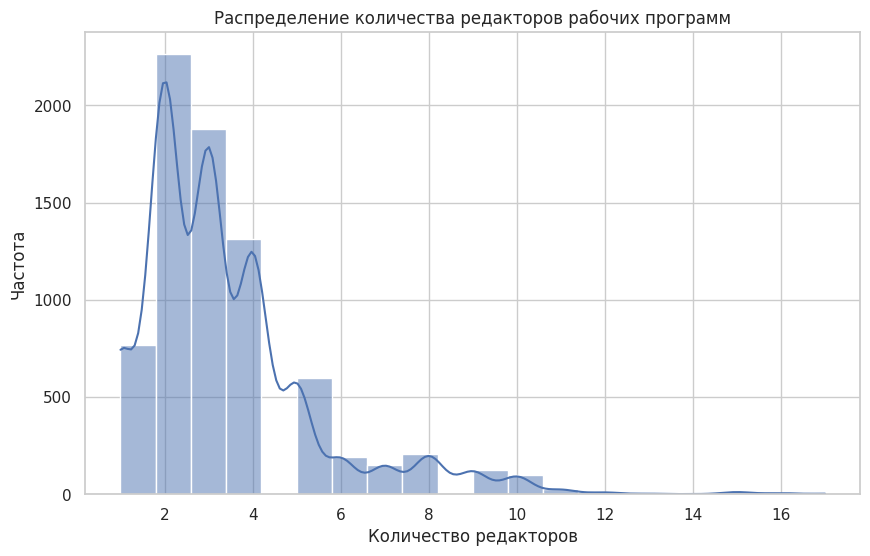

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x="user_count", bins=20, kde=True)

plt.title("Распределение количества редакторов рабочих программ")
plt.xlabel("Количество редакторов")
plt.ylabel("Частота")

# Показать гистограмму
plt.show()

### 2. Как со временем менялось среднее количество экспертиз РПД?

In [ ]:
data['approval_date_y'] = pd.to_datetime(data['approval_date_y'])

data['year_month'] = data['approval_date_y'].dt.to_period('M')
avg_expertise_count = data.groupby('year_month')['expertise_counter'].mean().reset_index()

<ipython-input-46-edf558b273f6>:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['year_month'] = data['approval_date_y'].dt.to_period('M')


In [ ]:
avg_expertise_count

,year_month,expertise_counter
0,2021-04,2.358974
1,2021-05,2.153846
2,2021-06,1.844660
3,2021-07,1.732026
4,2021-08,1.738562
5,2021-09,1.359155
6,2021-10,1.476190
7,2021-11,1.141892
8,2021-12,1.083333
9,2022-01,0.795276


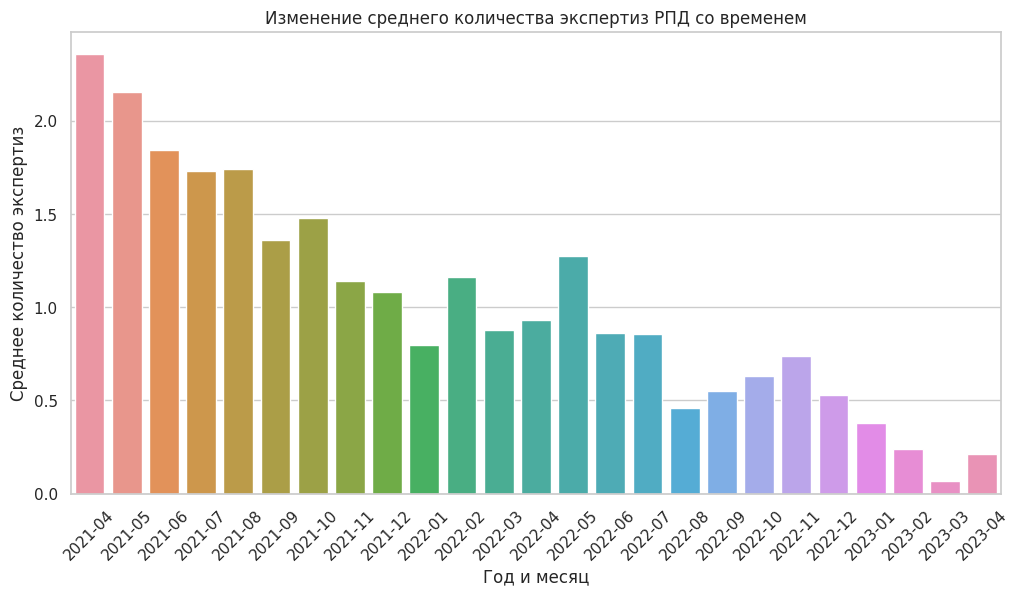

In [ ]:
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
sns.barplot(data=avg_expertise_count, x='year_month', y='expertise_counter')

plt.title("Изменение среднего количества экспертиз РПД со временем")
plt.xlabel("Год и месяц")
plt.ylabel("Среднее количество экспертиз")

plt.xticks(rotation=45)

plt.show()

### 3. Есть ли зависимость между датой и присвоением статуса "одобрено" (AC)?

In [ ]:
data['approval_date_y'] = pd.to_datetime(data['approval_date_y'])

approved_df = data[data['expertise_status'] == 'AC']

approved_df['approval_date_y'] = pd.to_datetime(approved_df['approval_date_y'])
approved_df['year_month'] = approved_df['approval_date_y'].dt.to_period('M')

count_by_date = approved_df.groupby('year_month').size().reset_index(name='count')

count_by_date

<ipython-input-57-6d7037c797c3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  approved_df['approval_date_y'] = pd.to_datetime(approved_df['approval_date_y'])
<ipython-input-57-6d7037c797c3>:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  approved_df['year_month'] = approved_df['approval_date_y'].dt.to_period('M')
<ipython-input-57-6d7037c797c3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  approved_df['year_month'] = approved_df['approval_date_y'].dt.to

,year_month,count
0,2021-04,39
1,2021-05,327
2,2021-06,81
3,2021-07,147
4,2021-08,145
5,2021-09,137
6,2021-10,121
7,2021-11,146
8,2021-12,219
9,2022-01,123


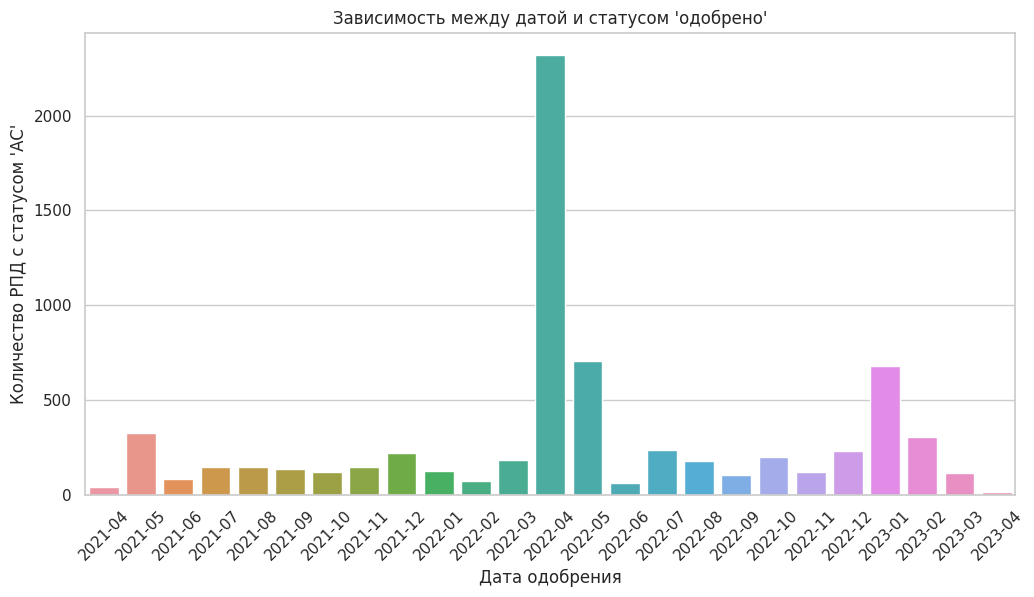

In [ ]:
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
sns.barplot(data=count_by_date, x='year_month', y='count')

plt.title("Зависимость между датой и статусом 'одобрено'")
plt.xlabel("Дата одобрения")
plt.ylabel("Количество РПД с статусом 'AC'")

plt.xticks(rotation=45)

plt.show()